<a href="https://colab.research.google.com/github/DataJenius/NLPEncodingExperiment/blob/main/python/NLPEncodingExperiment_custom300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#######################################################################################################
# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()

Finished!


In [2]:
###########################################
# load all dependencies
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from stepbystep.v4 import StepByStep

from google.colab import files

In [3]:
######################################################################################
# our one-hot encoded data is on github
all_files = ['https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom300/custom_encoded300_group1.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom300/custom_encoded300_group2.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom300/custom_encoded300_group3.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom300/custom_encoded300_group4.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/custom300/custom_encoded300_group5.csv']
# concat into a single dataframe and shuffle the contents
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_all_data   = pd.concat(df_from_each_file, ignore_index=True)
df_all_data = df_all_data.sample(frac=1).reset_index(drop=True)

# make sure we loaded what we think we did
print(df_all_data.head())
print(df_all_data.shape)

   msg_id  token_count  my_group my_role  label      dim1      dim2      dim3  \
0   36445           34         2   train      1 -0.007334 -0.003302 -0.001949   
1   11732           21         2   train      0 -0.008102 -0.000047  0.000267   
2   36589          117         5    test      1 -0.008147 -0.004036 -0.000819   
3   12409           15         3   train      0 -0.007888  0.001483 -0.001608   
4   13643           20         1   train      0 -0.008315  0.000842  0.000948   

       dim4      dim5  ...    dim291    dim292    dim293    dim294    dim295  \
0 -0.000612  0.001927  ... -0.004181  0.002530  0.001396 -0.005157 -0.001258   
1  0.006182 -0.000217  ... -0.000039  0.000148  0.000163  0.000348  0.000659   
2 -0.000930  0.001736  ... -0.000211 -0.000638 -0.000289 -0.000829 -0.000919   
3  0.003176 -0.001640  ... -0.000032  0.001056  0.003402  0.005641 -0.002827   
4  0.005558  0.000645  ...  0.000926 -0.000605  0.000411  0.000915 -0.000236   

     dim296    dim297    dim298 

In [4]:
######################################################################################
# our data is already split into 5 groups, encoded and fully labelled

# setup this experiment
test_input_method = 'custom (300)'
print(test_input_method+" loading data...")

# split into val/test/train based on validation group 
df_train = df_all_data.loc[df_all_data['my_group'].isin([1,2,3])]
df_val = df_all_data.loc[df_all_data['my_group'] == 4]
df_test = df_all_data.loc[df_all_data['my_group'] == 5]

print("\n\ntrain - groups ",df_train['my_group'].unique())
print(df_train.head())
print("\n\nval - group ",df_val['my_group'].unique())
print(df_val.head())
print("\n\ntest - group ",df_test['my_group'].unique())
print(df_test.head())

# extract our labels into tensors 
train_labels_tensor = torch.as_tensor(df_train['label'].to_numpy().reshape(-1, 1)).float()
val_labels_tensor = torch.as_tensor(df_val['label'].to_numpy().reshape(-1, 1)).float()
test_labels_tensor = torch.as_tensor(df_test['label'].to_numpy().reshape(-1, 1)).float()
print("\n\nLabel Tensors:")
print("train - ",train_labels_tensor.shape)
print("val - ",val_labels_tensor.shape)
print("test - ",test_labels_tensor.shape)


# extract our features into tensors 
df_train_features = df_train.loc[:, ~df_train.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
train_features_tensor = torch.as_tensor(df_train_features.to_numpy()).float()
df_val_features = df_val.loc[:, ~df_val.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
val_features_tensor = torch.as_tensor(df_val_features.to_numpy()).float()
df_test_features = df_test.loc[:, ~df_test.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
test_features_tensor = torch.as_tensor(df_test_features.to_numpy()).float()
print("\n\nFeature Tensors:")
print("train - ",train_features_tensor.shape)
print("val - ",val_features_tensor.shape)
print("test - ",test_features_tensor.shape)


custom (300) loading data...


train - groups  [2 3 1]
   msg_id  token_count  my_group my_role  label      dim1      dim2      dim3  \
0   36445           34         2   train      1 -0.007334 -0.003302 -0.001949   
1   11732           21         2   train      0 -0.008102 -0.000047  0.000267   
3   12409           15         3   train      0 -0.007888  0.001483 -0.001608   
4   13643           20         1   train      0 -0.008315  0.000842  0.000948   
5   44548           21         1   train      1 -0.007553 -0.005282 -0.000404   

       dim4      dim5  ...    dim291    dim292    dim293    dim294    dim295  \
0 -0.000612  0.001927  ... -0.004181  0.002530  0.001396 -0.005157 -0.001258   
1  0.006182 -0.000217  ... -0.000039  0.000148  0.000163  0.000348  0.000659   
3  0.003176 -0.001640  ... -0.000032  0.001056  0.003402  0.005641 -0.002827   
4  0.005558  0.000645  ...  0.000926 -0.000605  0.000411  0.000915 -0.000236   
5 -0.000185 -0.000033  ... -0.000702  0.000468 -0.000291  

In [5]:
######################################################################################
# build a TensorDataset containing ALL data points for train/val
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)

# build a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)
print(train_loader)
print(val_loader)

In [6]:
###############################################################################################
# use same model structure, just change embeddings into this one-hot input instead
torch.manual_seed(42)

# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/ 
model = nn.Sequential(
    nn.Linear(300, 1) 
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# get details about the model
def count_all_parameters(model):
    return sum(p.numel() for p in model.parameters())
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_all_parameters(model)
num_params_train = count_trainable_parameters(model)
print(model)
print(num_params, "total params")
print(num_params_train, "trainable params")

Sequential(
  (0): Linear(in_features=300, out_features=1, bias=True)
)
301 total params
301 trainable params


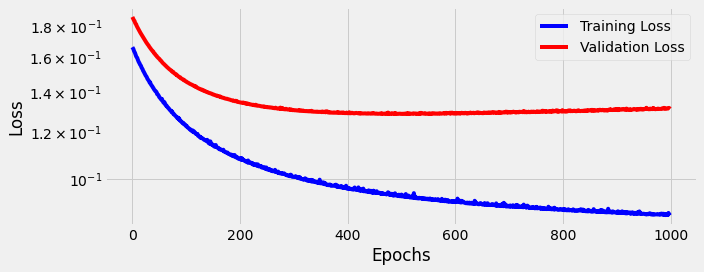

In [9]:
###############################################################################################
# train the model - only takes about 10s for 20 epochs, 1m for 100 epochs
sbs_oh = StepByStep(model, loss_fn, optimizer)
sbs_oh.set_loaders(train_loader, val_loader)
sbs_oh.train(100)

# plot loss over epochs
fig = sbs_oh.plot_losses()

In [10]:
##############################################################
# how well does this model do with data it has never seen?
sbs_oh.model.eval()
out = sbs_oh.model(test_features_tensor)

# record detailed predictions for this model
df_experiment_results = pd.DataFrame({'method': test_input_method,
                                      'params': num_params,
                                      'params_train': num_params_train, 
                                      'msg_id': df_test['msg_id'],
                                      'label': df_test['label'],
                                      'p_sigmoid': torch.sigmoid(out).squeeze().tolist()}) 
df_experiment_results['pred'] = np.where(df_experiment_results['p_sigmoid']>0.5, 1, 0)
df_experiment_results['correct'] = np.where(df_experiment_results['pred']==df_experiment_results['label'], 1, 0)
df_experiment_results['tp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==1), 1, 0)
df_experiment_results['fp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['tn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['fn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==1), 1, 0)

# calculate metrics
tp = df_experiment_results["tp"].sum()
fp = df_experiment_results["fp"].sum()
tn = df_experiment_results["tn"].sum()
fn = df_experiment_results["fn"].sum()
prec = tp/(tp+fp)
recall = tp/(tp+fn)

# show our metrics
print("ACC: ",df_experiment_results["correct"].mean())
print("Precision: ",prec)
print("Recall: ", recall)

# save results to local CSV
file_name = 'results_'+test_input_method+'.csv'
df_experiment_results.to_csv(file_name, index=False) 
files.download(file_name)
print("\n\n",df_experiment_results.head(10))

ACC:  0.9575
Precision:  0.9597989949748744
Recall:  0.955


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



           method  params  params_train  msg_id  label  p_sigmoid  pred  \
2   custom (300)     301           301   36589      1   0.985780     1   
7   custom (300)     301           301   26324      1   0.812046     1   
8   custom (300)     301           301    4337      0   0.264208     0   
10  custom (300)     301           301   20131      0   0.000960     0   
17  custom (300)     301           301   42817      1   0.995681     1   
20  custom (300)     301           301   18236      0   0.002434     0   
21  custom (300)     301           301   42413      1   0.341046     0   
28  custom (300)     301           301   13340      0   0.034147     0   
29  custom (300)     301           301   11306      0   0.002615     0   
38  custom (300)     301           301   24550      1   0.999928     1   

    correct  tp  fp  tn  fn  
2         1   1   0   0   0  
7         1   1   0   0   0  
8         1   0   0   1   0  
10        1   0   0   1   0  
17        1   1   0   0   0  
20